In [3]:
import torch

In [4]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='./data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}')
print('==================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0] # Get the first graph object
print(data)

Dataset: Cora()
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


# Node Classification with GNN

* Number of Layers: 2
* Activation: ReLU
* Dropout rate: 0.5

In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch.nn as nn

class GCN(nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    
model = GCN(hidden_channels=16)
print(model) # Show the model architecture

# Visualizing Untrained GCN Network

Node embedding of an untrained GCN network. This will plot 7 dimension node embedding to a 2D scatter plot

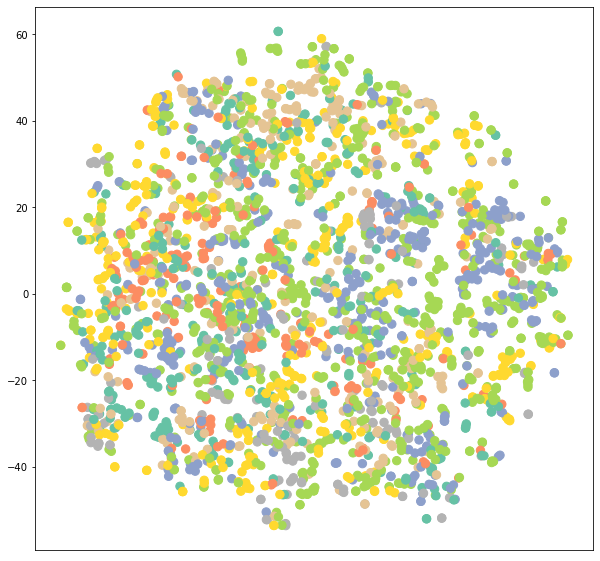

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    
    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks()
    
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    
# Evaluate the model
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

# Training GNN

* Number_of_epochs: 100
* Loss function: Cross-entropy loss
* Optimization: Adam

In the train function,

1. Clear the gradient
2. Performed a single forward pass
3. Compute loss using training nodes
4. Calculate gradient, and update the parameters

In the test function,

1. Predicted node class
2. Extracted class label with the highest probability
3. Checked how many values have been predicted correctly
4. Creating accuracy ratio using sum of correct predictions divided by a total number of nodes.

In [20]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
lossArr = []
num_epochs = 1000

def train():
    model.train()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    print(pred)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

for epoch in range(num_epochs):
    loss = train()
    lossArr.append(loss.item())
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 1.9458
Epoch: 001, Loss: 1.9401
Epoch: 002, Loss: 1.9333
Epoch: 003, Loss: 1.9258
Epoch: 004, Loss: 1.9175
Epoch: 005, Loss: 1.9072
Epoch: 006, Loss: 1.8948
Epoch: 007, Loss: 1.8830
Epoch: 008, Loss: 1.8722
Epoch: 009, Loss: 1.8542
Epoch: 010, Loss: 1.8435
Epoch: 011, Loss: 1.8245
Epoch: 012, Loss: 1.8145
Epoch: 013, Loss: 1.7975
Epoch: 014, Loss: 1.7809
Epoch: 015, Loss: 1.7619
Epoch: 016, Loss: 1.7293
Epoch: 017, Loss: 1.7322
Epoch: 018, Loss: 1.7000
Epoch: 019, Loss: 1.6814
Epoch: 020, Loss: 1.6520
Epoch: 021, Loss: 1.6400
Epoch: 022, Loss: 1.5990
Epoch: 023, Loss: 1.5728
Epoch: 024, Loss: 1.5313
Epoch: 025, Loss: 1.5323
Epoch: 026, Loss: 1.5034
Epoch: 027, Loss: 1.4836
Epoch: 028, Loss: 1.4217
Epoch: 029, Loss: 1.4419
Epoch: 030, Loss: 1.4232
Epoch: 031, Loss: 1.3856
Epoch: 032, Loss: 1.3593
Epoch: 033, Loss: 1.3056
Epoch: 034, Loss: 1.2792
Epoch: 035, Loss: 1.2520
Epoch: 036, Loss: 1.2654
Epoch: 037, Loss: 1.1928
Epoch: 038, Loss: 1.1542
Epoch: 039, Loss: 1.1505


tensor([3, 4, 4,  ..., 1, 3, 3])
Test Accuracy: 0.6940


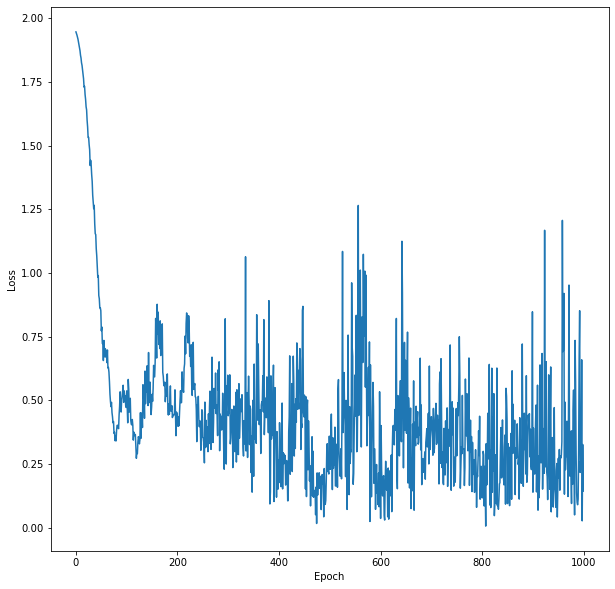

In [22]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

def plot_loss(lossArr):
  fig = plt.figure(figsize=(10, 10))
  plt.plot([i for i in range(num_epochs)], lossArr)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

plot_loss(lossArr)

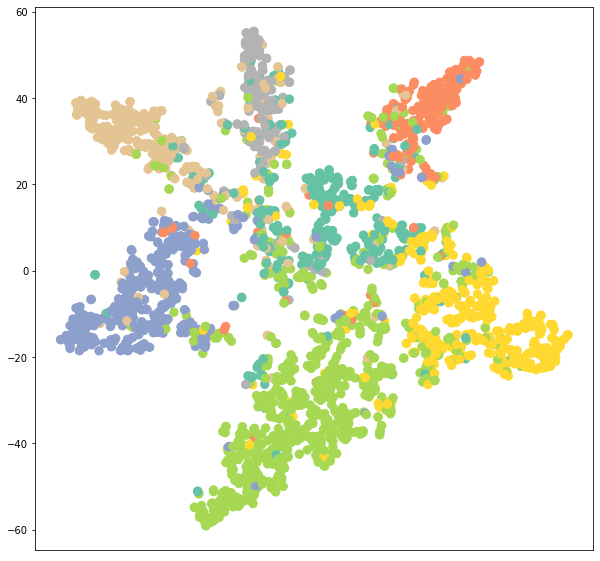

In [23]:
# Visualize the output of the trained model
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

# Training GATConv Model

* GATConv layers is used here
* 8 attention heads in the first layer
* 1 in the second layer

* Dropout rate: 0.65
* hidden channels: 8
* Learning rate: 0.0005

In [30]:
from torch_geometric.nn import GATConv

class GAT(nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads)
        self.conv2 = GATConv(heads * hidden_channels, dataset.num_classes, heads)
        
    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    
model = GAT(hidden_channels=16, heads=8)    
print(model)

GAT(
  (conv1): GATConv(1433, 16, heads=8)
  (conv2): GATConv(128, 7, heads=8)
)


In [33]:
# Trainig GAT
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 1000
lossArr = []
val_acc_all = []
test_acc_all = []

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc
    
for epoch in range(num_epochs):
    loss = train()
    lossArr.append(loss.item())
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    val_acc_all.append(val_acc)
    test_acc_all.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, val:{val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 000, Loss: 4.0279, val:0.4380, Test: 0.4200
Epoch: 001, Loss: 3.9974, val:0.4560, Test: 0.4590
Epoch: 002, Loss: 3.9638, val:0.4660, Test: 0.4730
Epoch: 003, Loss: 3.9253, val:0.4600, Test: 0.4610
Epoch: 004, Loss: 3.8765, val:0.4380, Test: 0.4440
Epoch: 005, Loss: 3.8257, val:0.4120, Test: 0.4300
Epoch: 006, Loss: 3.7624, val:0.3920, Test: 0.4200
Epoch: 007, Loss: 3.6917, val:0.3920, Test: 0.4200
Epoch: 008, Loss: 3.6086, val:0.3980, Test: 0.4250
Epoch: 009, Loss: 3.5182, val:0.4060, Test: 0.4260
Epoch: 010, Loss: 3.4136, val:0.4100, Test: 0.4290
Epoch: 011, Loss: 3.3133, val:0.4200, Test: 0.4370
Epoch: 012, Loss: 3.2203, val:0.4180, Test: 0.4420
Epoch: 013, Loss: 3.0708, val:0.4180, Test: 0.4460
Epoch: 014, Loss: 2.9581, val:0.4260, Test: 0.4400
Epoch: 015, Loss: 2.8241, val:0.4280, Test: 0.4430
Epoch: 016, Loss: 2.7054, val:0.4340, Test: 0.4410
Epoch: 017, Loss: 2.5899, val:0.4240, Test: 0.4390
Epoch: 018, Loss: 2.4710, val:0.4140, Test: 0.4400
Epoch: 019, Loss: 2.3605, val:0

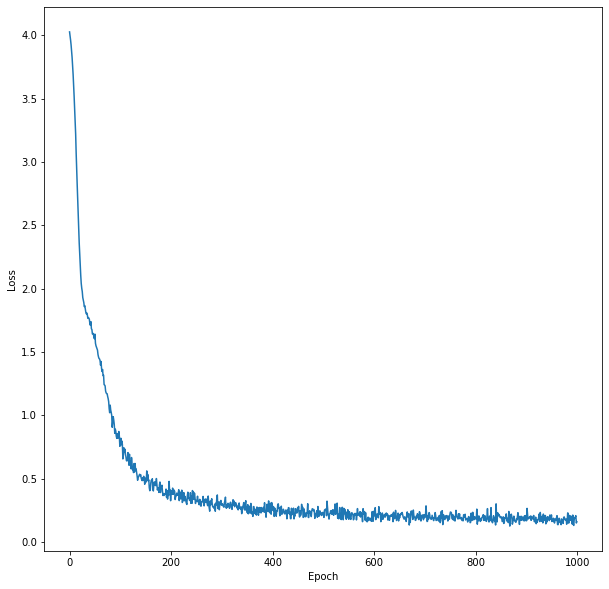

In [34]:
# Plot the loss
plot_loss(lossArr)

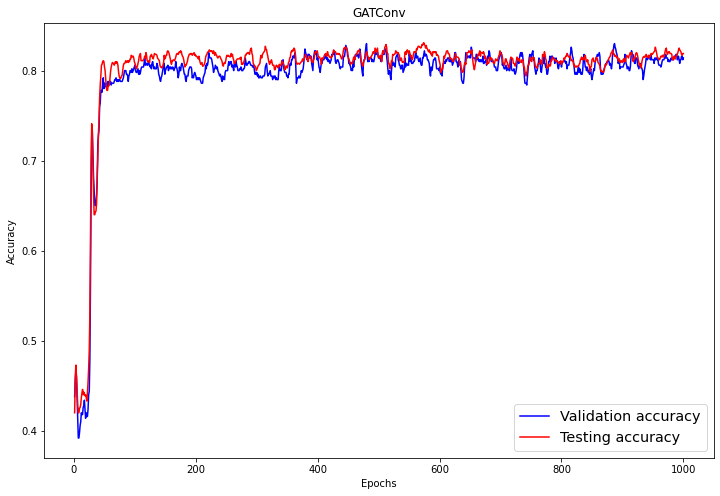

In [37]:
# Model Evaluation
import numpy as np

plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, len(val_acc_all) + 1), val_acc_all, label='Validation accuracy', c='blue')
plt.plot(np.arange(1, len(test_acc_all) + 1), test_acc_all, label='Testing accuracy', c='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('GATConv')
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('./Images/gat_loss.png')
plt.show()

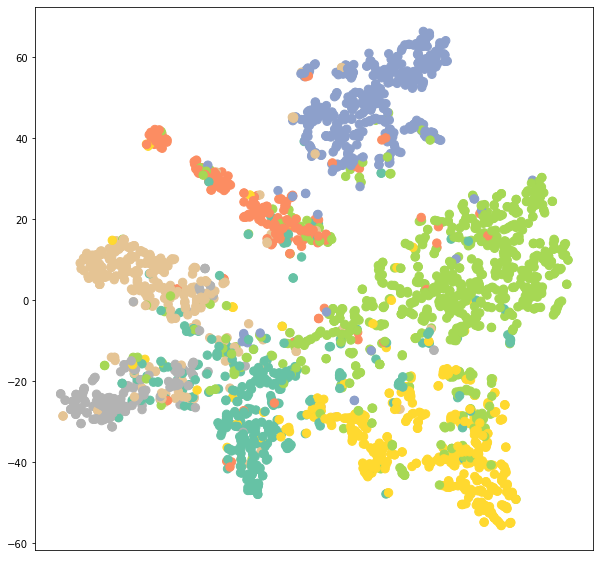

In [38]:
# Visualize the embedding
model.eval()
out = model(data.x ,data.edge_index)
visualize(out, color=data.y)